# About this notebook

**In this notebook we will analyze how Prophet creates predictions for new dates. Firstly, we will train model for synthetic data and then we will go step by step through prediction process.**


# Load libraries

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating functions for data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

# Generate features

In [4]:
np.random.seed(123)
Time = np.arange(0, 200)
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

# Plotting features

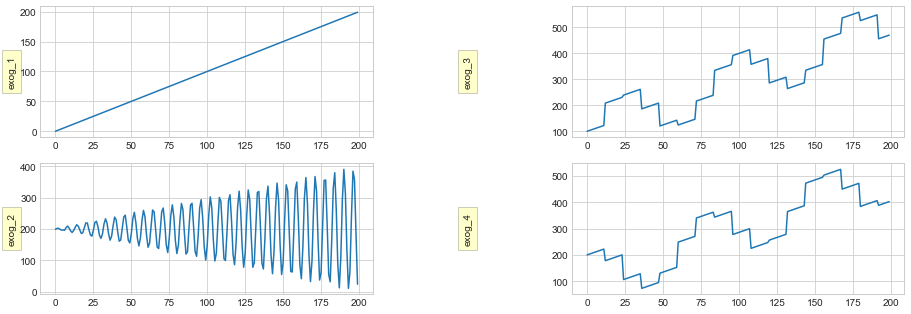

In [5]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots

fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)

ax1.plot(Time,Exog[:,0])
ax1.set_ylabel('exog_1', bbox=box)


ax3.set_ylabel('exog_2',bbox=box)
ax3.plot(Time,Exog[:,1])

labelx = -0.3  # axes coords

ax2.plot(Time,Exog[:,2])
ax2.set_ylabel('exog_3', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


ax4.plot(Time,Exog[:,3])
ax4.set_ylabel('exog_4', bbox=box)
ax4.yaxis.set_label_coords(labelx, 0.5)

plt.show()

# Generate and plot time-series

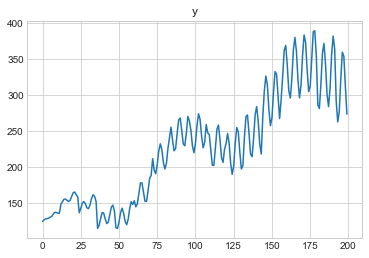

In [6]:
y = generate_ts_1(Exog)

plt.plot(Time, y)
plt.title("y")
plt.show()

# Data preprocessing for Prophet

In [7]:
data = pd.DataFrame(y)
data.columns = ["y"]
data["ds"] = pd.date_range(start='1/1/2018', periods=len(data), freq='M')


exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data.shape, exog.shape)

(200, 2) (200, 5)


In [8]:
data.head()

,y,ds
0,124.728592,2018-01-31
1,126.709704,2018-02-28
2,128.025393,2018-03-31
3,128.479266,2018-04-30
4,129.098547,2018-05-31


In [9]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,198.914369,100.0,200.0,2018-01-31
1,1.0,201.838816,102.0,202.0,2018-02-28
2,2.0,202.101573,104.0,204.0,2018-03-31
3,3.0,198.917065,106.0,206.0,2018-04-30
4,4.0,196.394190,108.0,208.0,2018-05-31


# Train-test-split

In [10]:
N = 100

data_train = data.iloc[:N]
data_test = data.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

In [11]:
y_test = data_test["y"].values
del data_test["y"]

# model without exog

In [12]:
# Python
model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

model.fit(data_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [13]:
forecast = model.predict(data_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,530.146083,469.060315,594.759508
96,2034-05-31,544.039858,481.138100,606.891259
97,2034-06-30,546.223158,480.779665,612.407325
98,2034-07-31,543.311946,478.414266,606.298472
99,2034-08-31,540.546962,475.243192,608.976595


In [14]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.289 
 MAE:  121.102


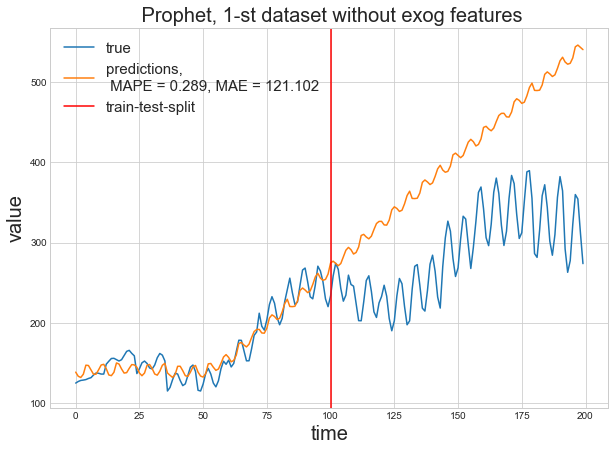

In [15]:
forecast_test = model.predict(data_test)
forecast_train = model.predict(data_train)

plt.figure(figsize=(10,7))

plt.plot(Time, y, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Merging of features

In [16]:
data_train_joined = pd.merge(data_train, exog_train, on = "ds")

data_test_joined = pd.merge(data_test, exog_test, on = "ds")

print(data_train_joined.shape, data_test_joined.shape)
data_train_joined.head()

(100, 6) (100, 5)


,y,ds,f1,f2,f3,f4
0,124.728592,2018-01-31,0.0,198.914369,100.0,200.0
1,126.709704,2018-02-28,1.0,201.838816,102.0,202.0
2,128.025393,2018-03-31,2.0,202.101573,104.0,204.0
3,128.479266,2018-04-30,3.0,198.917065,106.0,206.0
4,129.098547,2018-05-31,4.0,196.394190,108.0,208.0


# Model with exog features

In [17]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_joined)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
forecast = model.predict(data_test_joined)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,322.601625,320.873609,324.649396
96,2034-05-31,359.930365,358.183179,362.029629
97,2034-06-30,354.376263,352.582558,356.495667
98,2034-07-31,312.435106,310.649405,314.595970
99,2034-08-31,273.786247,271.962417,275.966977


In [19]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.055


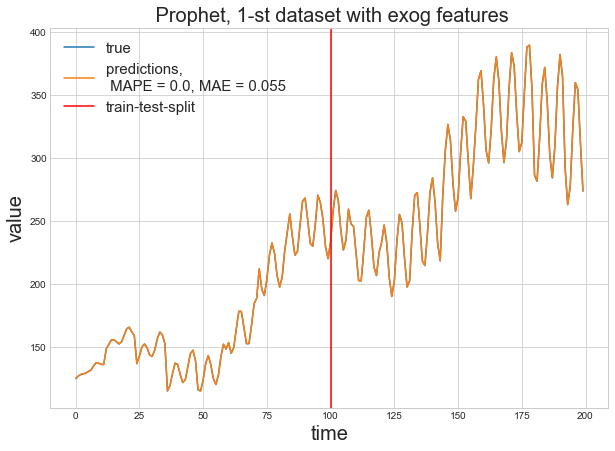

In [20]:
forecast_test = model.predict(data_test_joined)
forecast_train = model.predict(data_train_joined)

plt.figure(figsize=(10,7))

plt.plot(Time, y, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

**As we can see, after we added exogenous features, we were able to find linear regression on these features and obtain a perfect result.**

# Parameters analyzing

**Prophet have 5 training parameters: $k$ - base trend, $m$ - offset parameter, $\delta$ - changing of trend in changepoints, $\beta$ - parameters for Fourier series (seasonal component) and extra regressors (exogenous features), $\sigma$ - level of noise.**

In [21]:
model.params

{'k': array([[0.32502272]]),
 'm': array([[0.46115952]]),
 'delta': array([[ 1.86126451e-03, -2.05610117e-03,  1.00902816e-03,
         -1.93936936e-03,  1.09542858e-03,  7.69374428e-06,
         -1.59931867e-03,  4.43941961e-04,  1.94334331e-03,
         -1.08225443e-03, -7.28897483e-04,  1.79435277e-04,
          3.08523760e-03, -2.93056264e-03,  2.89929017e-04,
          5.98132482e-04, -3.28892552e-04, -1.19094434e-03,
          6.86451895e-04,  2.06285389e-03, -1.52088754e-03,
         -2.47928689e-03,  2.52326522e-03, -9.54217508e-04,
          1.19593685e-03]]),
 'sigma_obs': array([[0.00016636]]),
 'beta': array([[ 5.49624498e-05, -5.96604744e-05,  4.15601576e-05,
          2.28579948e-05,  1.41261934e-05,  1.26076713e-05,
          1.73469088e-05,  7.75187286e-06,  1.48641724e-05,
         -1.28977262e-05,  2.37971360e-05,  1.30580349e-05,
          4.98824210e-05,  1.93768839e-05,  3.60446522e-05,
          7.53668557e-06,  4.44621735e-05, -2.68189957e-05,
          6.8021784

# Prediction

**First of all we will write final formula for prediction and then we will go step by step, how to obtain this prediction.**

**So, it is the final formula for prediction, that don't take into account some detailes, for example that time is standartized.**

$$
\small
\begin{eqnarray}
y_t = \left[(k + \sum_{i \in changepoints}\delta_i) * t + m + \sum_{i \in changepoints}(-changepoint_i * \delta_i)\right] * \\ *  
\left[1 + \sum_{multiplicative-features} \beta \left( \sum_{i \in seasonal-features}  ([i \% 2 == 0] * Cos\left(\frac{2 * \pi * t}{period}\right) + [i \% 2 == 1] * Sin\left(\frac{2 * \pi * t}{period}\right)  + \sum_{i \in regressors} \frac{regressors_i - mu_{train}}{std_{train}}\right] \right) + \\
+ \sum_{additive-features} * y_{scale} * \beta \left( \sum_{i \in seasonal-features} ([i \% 2 == 0] * Cos\left(\frac{2 * \pi * t}{period}\right) + [i \% 2 == 1] * Sin\left(\frac{2 * \pi * t}{period}\right) + \sum_{i \in regressors} \frac{regressors_i - mu_{train}}{std_{train}} \right)
\end{eqnarray}
$$

# Example of 2 regressors and 2 seasonal components with different periods

**Let's look at the model in which we will make a prediction for only several firsts points from the test data. Also we will consider two multiplicative seasonal components (yearly, montly ) with fourier order is equal to 1. And we will add two regressors, one with multiplicative order, anoyjer one with additive order. **

In [22]:
data_train.head(5)

,y,ds
0,124.728592,2018-01-31
1,126.709704,2018-02-28
2,128.025393,2018-03-31
3,128.479266,2018-04-30
4,129.098547,2018-05-31


In [23]:
exog_train.head(5)

,f1,f2,f3,f4,ds
0,0.0,198.914369,100.0,200.0,2018-01-31
1,1.0,201.838816,102.0,202.0,2018-02-28
2,2.0,202.101573,104.0,204.0,2018-03-31
3,3.0,198.917065,106.0,206.0,2018-04-30
4,4.0,196.394190,108.0,208.0,2018-05-31


In [24]:
# Create joined dataset with 2 regressors
data_train_joined_2_regressor = pd.merge(data_train, exog_train[["f1", "f2", "ds"]], on = "ds")

data_test_joined_2_regressor = pd.merge(data_test, exog_test[["f1", "f2", "ds"]], on = "ds")

# There we will take just 3 points for prediction
data_test_joined_2_regressor = data_test_joined_2_regressor[:3].copy()



print(data_train_joined_2_regressor.shape, data_test_joined_2_regressor.shape)
data_train_joined_2_regressor.head()

(100, 4) (3, 3)


,y,ds,f1,f2
0,124.728592,2018-01-31,0.0,198.914369
1,126.709704,2018-02-28,1.0,201.838816
2,128.025393,2018-03-31,2.0,202.101573
3,128.479266,2018-04-30,3.0,198.917065
4,129.098547,2018-05-31,4.0,196.394190


In [25]:
data_test_joined_2_regressor

,ds,f1,f2
0,2026-05-31,100.0,150.005491
1,2026-06-30,101.0,243.676717
2,2026-07-31,102.0,302.184597


In [26]:
# There we create model with only one checkpoint
model = Prophet(n_changepoints = 1)

# There wу add 2 seasonal components with multiplicative mode
model.add_seasonality(name='yearly', period = 12, fourier_order = 1, prior_scale = 0.1, mode = 'multiplicative')
model.add_seasonality(name='monthly', period = 30, fourier_order = 1, prior_scale = 0.1, mode = 'multiplicative')

# There we add 1 regressor with multiplicative mode and 1 regressor with additive mode
model.add_regressor("f1", mode = "multiplicative")
model.add_regressor("f2", mode = "additive")

In [27]:
# There we fit our model
model.fit(data_train_joined_2_regressor)

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
# There we check seasonalities
model.seasonalities

{'yearly': {'period': 12,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'},
 'monthly': {'period': 30,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

In [29]:
# Prediction
forecast = model.predict(data_test_joined_2_regressor)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2026-05-31,206.923049,224.160855,242.961783,206.923049,206.923049,-11.870705,-11.870705,-11.870705,-11.870705,...,0.053624,0.053624,0.053624,0.184549,0.184549,0.184549,-0.000227,-0.000227,-0.000227,233.239699
1,2026-06-30,208.358655,248.154298,267.581976,208.358655,208.358655,10.601852,10.601852,10.601852,10.601852,...,0.053624,0.053624,0.053624,0.187599,0.187599,0.187599,0.000227,0.000227,0.000227,258.048438
2,2026-07-31,209.842114,256.853392,275.676006,209.842114,209.842114,24.638410,24.638410,24.638410,24.638410,...,0.015615,0.015615,0.015615,0.149747,0.149747,0.149747,-0.002213,-0.002213,-0.002213,265.903811


In [30]:
# Let's see the parameters of the model
model.params

{'k': array([[0.21116757]]),
 'm': array([[0.48348259]]),
 'delta': array([[0.32148656]]),
 'sigma_obs': array([[0.02877962]]),
 'beta': array([[-0.00403334, -0.00022682, -0.10575026, -0.15193533,  0.07534458,
          0.03651329]])}

**Let's create dataframe from our dataframe, using their function. This function just take initial dataframe and does some transformations and preprocessing: scaling of the target (y_scaled), creates columns "t", that is just scale of time to range \[0, 1\], sdandartizing of features, that is just subtraction of training mean and division by training variance per column.**

In [31]:
df_train = model.setup_dataframe(data_train_joined_2_regressor)
df_train.head(5)

,y,ds,f1,f2,floor,t,y_scaled
0,124.728592,2018-01-31,-1.706220,-0.013874,0,0.000000,0.461091
1,126.709704,2018-02-28,-1.671751,0.057159,0,0.009299,0.468415
2,128.025393,2018-03-31,-1.637282,0.063541,0,0.019595,0.473279
3,128.479266,2018-04-30,-1.602813,-0.013808,0,0.029558,0.474956
4,129.098547,2018-05-31,-1.568344,-0.075087,0,0.039854,0.477246


In [32]:
df_test = model.setup_dataframe(data_test_joined_2_regressor)
df_test.head(5)

,ds,f1,f2,floor,t
0,2026-05-31,1.740690,-1.201839,0,1.010296
1,2026-06-30,1.775159,1.073375,0,1.020259
2,2026-07-31,1.809628,2.494494,0,1.030555


**Let's check, for example, standartizing of the regressors.**

In [33]:
mu_train = data_train_joined_2_regressor['f1'].mean()
std_train = data_train_joined_2_regressor['f1'].std()

((data_test_joined_2_regressor['f1'] - mu_train) / std_train)

0    1.740690
1    1.775159
2    1.809628
Name: f1, dtype: float64

**As we can see we have obtained the same result.**

**Standartizing of the time.**

In [34]:
# Start of the time
start = data_train_joined_2_regressor["ds"].min()

# Timedelta to the end of training data
t_scale = data_train_joined_2_regressor["ds"].max() - start 

# scaled time to the range [0, 1]
t = ((data_test_joined_2_regressor["ds"] - start) / t_scale).values
t

array([1.01029558, 1.02025905, 1.03055463])

**So, we obtained standartization of features and time, using parameters $\mu$ and $\sigma$ that were calculated using train data. The results are the similar.**

In [35]:
changepoint_ts = model.changepoints_t
changepoint_ts

array([0.79840585])

**This is the changepoint that was obtained for already standartized time.**

**Next step is to obtain $k$ and $m$ as initial points for stan optimization.**

In [36]:
# Just extracted the indices of the minimum and maximum
i0, i1 = df_train['ds'].idxmin(), df_train['ds'].idxmax()

# Calculate the time difference for a standardized time
T = df_train['t'].iloc[i1] - df_train['t'].iloc[i0] 

# Calculate k
k = (df_train['y_scaled'].iloc[i1] - df_train['y_scaled'].iloc[i0]) / T

# Calculate m
m = df_train['y_scaled'].iloc[i0] - k * df_train['t'].iloc[i0]

k, m

(0.35227382535166263, 0.4610911275293851)

**After stan optimization we will have the following parameters.**

In [37]:
k = np.nanmean(model.params['k'])
m = np.nanmean(model.params['m'])
k, m

(0.21116756862063163, 0.48348258648098685)

In [38]:
deltas = np.nanmean(model.params['delta'], axis = 0)
gammas = -changepoint_ts * deltas

**The code below describes how to calculate trend component of prediction.**

In [39]:
gammas = -changepoint_ts * deltas

k_t = k * np.ones_like(t)
m_t = m * np.ones_like(t)

for s, t_s in enumerate(changepoint_ts):
    indx = t >= t_s
    k_t[indx] += deltas[s]
    m_t[indx] += gammas[s]

trend = k_t * t + m_t

**After that trend component calculates as follows**

In [40]:
floor = 0
trend = trend * model.y_scale + floor

In [41]:
trend

array([206.92304949, 208.35865478, 209.84211358])

In [42]:
forecast.trend

0    206.923049
1    208.358655
2    209.842114
Name: trend, dtype: float64

**As we can see, we have obtained the same results. So, now the next step is to find out how to calculate seasonal_components. To do this we will explore 2 functions, that are used to predict seasonal components.**

In [43]:
seasonal_components = model.predict_seasonal_components(df_test)
seasonal_components.head(5)

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,f1,...,f2_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper
0,-11.870705,-11.870705,-11.870705,-11.870705,-11.870705,-11.870705,0.131152,0.131152,0.131152,0.131152,...,-11.870705,0.053624,0.053624,0.053624,0.184549,0.184549,0.184549,-0.000227,-0.000227,-0.000227
1,10.601852,10.601852,10.601852,10.601852,10.601852,10.601852,0.133749,0.133749,0.133749,0.133749,...,10.601852,0.053624,0.053624,0.053624,0.187599,0.187599,0.187599,0.000227,0.000227,0.000227
2,24.638410,24.638410,24.638410,24.638410,24.638410,24.638410,0.136346,0.136346,0.136346,0.136346,...,24.638410,0.015615,0.015615,0.015615,0.149747,0.149747,0.149747,-0.002213,-0.002213,-0.002213


In [44]:
seasonal_features, _, component_cols, _ = model.make_all_seasonality_features(df_test)

In [45]:
seasonal_features.head(5)

,yearly_delim_1,yearly_delim_2,monthly_delim_1,monthly_delim_2,f1,f2
0,-8.681856e-13,1.000000,-0.951057,0.309017,1.740690,-1.201839
1,-7.832139e-13,-1.000000,-0.951057,0.309017,1.775159,1.073375
2,5.000000e-01,0.866025,-0.866025,0.500000,1.809628,2.494494


**In the dataframe seasonal features we have the following data:
First two columns are responsable for yearly seasonal component, and so we have fourier coefficients in this columns for yearly component. In The 3rd and the 4-th columns fourier coefficient for monthly seasonal component, and finally in the 5-th and the 6-th columns we have just standartized regressors.**


**Formulas for calculating coefficients in the columns, that are responsible for seasonal components are the following: this formulas for columns for one seasonal component**

$$
A[i, j] = [j \% 2 == 0]*Cos(2 \pi i (j + 1) / period) + [j \% 2 == 1]*Sin(2 \pi i (j + 1) / period)
$$

where $i$ is a time index and $j$ is a fourier order for the component

**There we create t, to calculate fourier series**

In [46]:
t = np.array(
    (data_test_joined_2_regressor["ds"] - pd.datetime(1970, 1, 1))
    .dt.total_seconds()
    .astype(np.float)
) / (3600 * 24.)
t

array([20604., 20634., 20665.])

In [47]:
model.seasonalities

{'yearly': {'period': 12,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'},
 'monthly': {'period': 30,
  'fourier_order': 1,
  'prior_scale': 0.1,
  'mode': 'multiplicative'}}

**That formula calculates the fourier coefficients for yearly seasonal component.**

In [48]:
period = model.seasonalities['yearly']["period"]
series_order = model.seasonalities["yearly"]["fourier_order"]

np.column_stack([
    fun((2.0 * (i + 1) * np.pi * t / period))
    for i in range(series_order)
    for fun in (np.sin, np.cos)
])

array([[-8.68185634e-13,  1.00000000e+00],
       [-7.83213903e-13, -1.00000000e+00],
       [ 5.00000000e-01,  8.66025404e-01]])

**Note that for the seasonal component were obtained the same coefficients, + the regressor is also the same.**

**Now we will understand how to obtain the matrix component_cols**

In [49]:
component_cols

component,additive_terms,extra_regressors_additive,extra_regressors_multiplicative,f1,f2,monthly,multiplicative_terms,yearly
col,,,,,,,,
0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,1,0
3,0,0,0,0,0,1,1,0
4,0,0,1,1,0,0,1,0
5,1,1,0,0,1,0,0,0


**It's just a cross-tab matrix that shows for each feature what columns it met in seasonal_matrix + there we  added some special names to distinguish between regressors and not regressors and so on. **

**Now we understand how to take into account "additive_terms" and "multiplicative_terms" for the final prediction. Note that these two columns will always be in obtained dataframes for seasonal components, and their sum will always be equal to 1.**

In [50]:
# Extract the data
X = seasonal_features.values

# For each seasonal component we calculate
for component in component_cols.columns:
    
    # Here, in fact, we leave the beta non-zero only in those positions where we have 1
    # This is equivalent to the fact that we just made up a mask so that later in the matrix seasonal_features take
    # only the parameters we need
    beta_c = model.params['beta'] * component_cols[component].values
    
    # This is a basic dot product, that is, for each date it's easy
    # multiply the scaled value by the trained beta and add
    # only the parameters that we need
    comp = np.matmul(X, beta_c.transpose())
    
    # If we have additive feature, then we should scale, that is also obvious
    if component in model.component_modes['additive']:
         comp *= model.y_scale
    
    # Exactly this will be in  'multiplicative' and 'additive'
    df_test[component] = np.nanmean(comp, axis=1)
    

In [51]:
df_test

,ds,f1,f2,floor,t,additive_terms,extra_regressors_additive,extra_regressors_multiplicative,monthly,multiplicative_terms,yearly
0,2026-05-31,0.131152,-11.870705,0,1.010296,-11.870705,-11.870705,0.131152,0.053624,0.184549,-0.000227
1,2026-06-30,0.133749,10.601852,0,1.020259,10.601852,10.601852,0.133749,0.053624,0.187599,0.000227
2,2026-07-31,0.136346,24.638410,0,1.030555,24.638410,24.638410,0.136346,0.015615,0.149747,-0.002213


**Let us denote by $r_1$, $r_2$ standartized value for regressor $f_1$ anf $f_2$ respectively.**
**$\phi_{sin_Y}$, $\phi_{cos_Y}$ denotes the fourier coefficient for yearly seasonal component.**
**$\phi_{sin_M}$, $\phi_{cos_M}$ denotes the fourier coefficient for monthly seasonal component.**

**Then the multiplicative term in this case will be just $\phi_{sin_Y} * \beta_{0} + \phi_{cos_Y} * \beta_{1}$ + $\phi_{sin_M} * \beta_{2} + \phi_{cos_M} * \beta_{3} + r_1 * \beta_4$**
**And additive will be $r_2 \beta_5$**

**Let's check this:**

In [52]:
additive = model.params["beta"].squeeze()[5] * seasonal_features["f2"] * model.y_scale
additive

0   -11.870705
1    10.601852
2    24.638410
Name: f2, dtype: float64

In [53]:
seasonal_components["additive_terms"]

0   -11.870705
1    10.601852
2    24.638410
Name: additive_terms, dtype: float64

**We have obtained the same additive terms.**

In [54]:
multiplicative = (model.params["beta"].squeeze()[0] * seasonal_features["yearly_delim_1"] + 
        model.params["beta"].squeeze()[1] * seasonal_features["yearly_delim_2"] + 
        model.params["beta"].squeeze()[2] * seasonal_features["monthly_delim_1"] + 
        model.params["beta"].squeeze()[3] * seasonal_features["monthly_delim_2"] + 
        model.params["beta"].squeeze()[4] * seasonal_features["f1"])
multiplicative

0    0.184549
1    0.187599
2    0.149747
dtype: float64

In [55]:
seasonal_components["multiplicative_terms"]

0    0.184549
1    0.187599
2    0.149747
Name: multiplicative_terms, dtype: float64

**Additive и multiplicative are the same. So, the final prediction is:**

In [56]:
pred = trend * (1 + multiplicative) + additive
pred

0    233.239699
1    258.048438
2    265.903811
dtype: float64

In [57]:
forecast = model.predict(data_test_joined_2_regressor)
forecast["yhat"]

0    233.239699
1    258.048438
2    265.903811
Name: yhat, dtype: float64

**Everything is fine. OK :-)**